In [1]:
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.model_selection import KFold

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib  inline

In [2]:
train =  pd.read_csv('train_bike.csv',  parse_dates = ['datetime'])
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
test = pd.read_csv('test_bike.csv', parse_dates = ['datetime'])
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


# 前処理

## datetime を変換する

In [5]:
#train['datetime'].datetime.day のイメージ
import datetime as dt
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['weekday'] = train.datetime.dt.weekday
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['weekday'] = test.datetime.dt.weekday
test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month

## 目的変数と説明変数に分ける

In [6]:
train_0 = train.drop(columns = ['datetime', 'casual', 'registered', 'count']) # 説明変数 
train_y = train['count']                                                      # 目的変数
test_0 = test.drop(columns = ['datetime'])
test_datetime = test['datetime']

## 対数を取る(右に偏っているとき)(必要に応じて行う)

In [7]:
train_y_log = np.log1p(train_y+1)

In [18]:
# 確認
train_0

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,hour,weekday,year,month
0,1,0,0,1,9.84,14.395,81,0.0000,1,0,5,2011,1
1,1,0,0,1,9.02,13.635,80,0.0000,1,1,5,2011,1
2,1,0,0,1,9.02,13.635,80,0.0000,1,2,5,2011,1
3,1,0,0,1,9.84,14.395,75,0.0000,1,3,5,2011,1
4,1,0,0,1,9.84,14.395,75,0.0000,1,4,5,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,19,19,2,2012,12
10882,4,0,1,1,14.76,17.425,57,15.0013,19,20,2,2012,12
10883,4,0,1,1,13.94,15.910,61,15.0013,19,21,2,2012,12
10884,4,0,1,1,13.94,17.425,61,6.0032,19,22,2,2012,12


# 可視化

## count と説明変数の関係

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Weekday vs Count')]

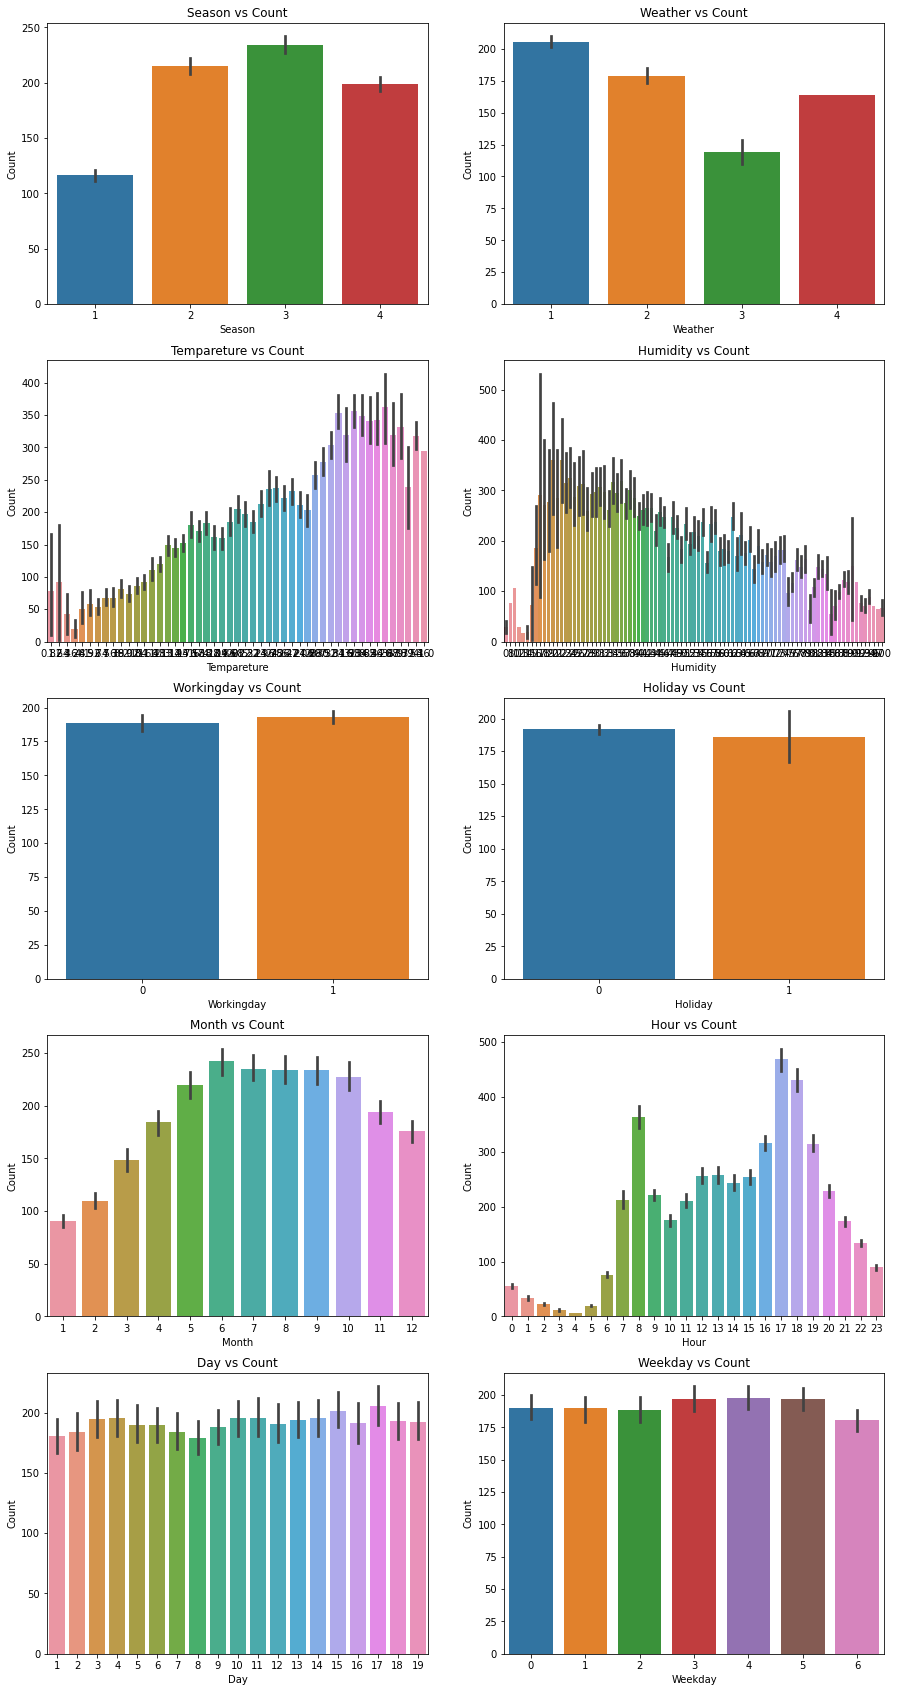

In [11]:
fig, axes = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(15, 30)
sns.barplot(data=train,y="count",x="season",orient="v",ax=axes[0][0])
sns.barplot(data=train,y="count",x="weather",orient="v",ax=axes[0][1])
sns.barplot(data=train,y="count",x="temp",orient="v",ax=axes[1][0])
sns.barplot(data=train,y="count",x="humidity",orient="v",ax=axes[1][1])
sns.barplot(data=train,y="count",x="workingday",orient="v",ax=axes[2][0])
sns.barplot(data=train,y="count",x="holiday",orient="v",ax=axes[2][1])
sns.barplot(data=train,y="count",x="month",orient="v",ax=axes[3][0])
sns.barplot(data=train,y="count",x="hour",orient="v",ax=axes[3][1])
sns.barplot(data=train,y="count",x="day",orient="v",ax=axes[4][0])
sns.barplot(data=train,y="count",x="weekday",orient="v",ax=axes[4][1])

axes[0][0].set(xlabel='Season', ylabel='Count',title="Season vs Count")
axes[0][1].set(xlabel='Weather', ylabel='Count',title="Weather vs Count")
axes[1][0].set(xlabel='Tempareture', ylabel='Count',title="Tempareture vs Count")
axes[1][1].set(xlabel='Humidity', ylabel='Count',title="Humidity vs Count")
axes[2][0].set(xlabel='Workingday', ylabel='Count',title="Workingday vs Count")
axes[2][1].set(xlabel='Holiday', ylabel='Count',title="Holiday vs Count")
axes[3][0].set(xlabel='Month', ylabel='Count',title="Month vs Count")
axes[3][1].set(xlabel='Hour', ylabel='Count',title="Hour vs Count")
axes[4][0].set(xlabel='Day', ylabel='Count',title="Day vs Count")
axes[4][1].set(xlabel='Weekday', ylabel='Count',title="Weekday vs Count")

In [24]:
train[['count', 'season']].groupby(['season'], as_index = True).mean().sort_values(by = 'count')

,count
season,
1,116.343261
4,198.988296
2,215.251372
3,234.417124


In [25]:
train[['count', 'weather']].groupby(['weather'], as_index = True).mean().sort_values(by = 'count')

,count
weather,
3,118.846333
4,164.000000
2,178.955540
1,205.236791


In [26]:
train[['count', 'holiday']].groupby(['holiday'], as_index = True).mean().sort_values(by = 'count')

,count
holiday,
1,185.877814
0,191.741655


In [27]:
train[['count', 'workingday']].groupby(['workingday'], as_index = True).mean().sort_values(by = 'count')

,count
workingday,
0,188.506621
1,193.011873


In [28]:
train[['count', 'day']].groupby(['day'], as_index = True).mean().sort_values(by = 'count')

,count
day,
8,179.041812
1,180.333913
7,183.773519
2,183.910995
9,187.897391
5,189.765217
6,189.860140
12,190.675393
16,191.353659


In [29]:
train[['count', 'hour']].groupby(['hour'], as_index = True).mean().sort_values(by = 'count')

,count
hour,
4,6.407240
3,11.757506
5,19.767699
2,22.899554
1,33.859031
0,55.138462
6,76.259341
23,89.508772
22,133.576754


In [30]:
train[['count', 'weekday']].groupby(['weekday'], as_index = True).mean().sort_values(by = 'count')

,count
weekday,
6,180.839772
2,188.411348
1,189.723847
0,190.390716
5,196.665404
3,197.296201
4,197.844343


In [31]:
train[['count', 'month']].groupby(['month'], as_index = True).mean().sort_values(by = 'count')

,count
month,
1,90.366516
2,110.003330
3,148.169811
12,175.614035
4,184.160616
11,193.677278
5,219.459430
10,227.699232
9,233.805281


## casual と説明変数の関係

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Casual'),
 Text(0.5, 1.0, 'Weekday vs Casual')]

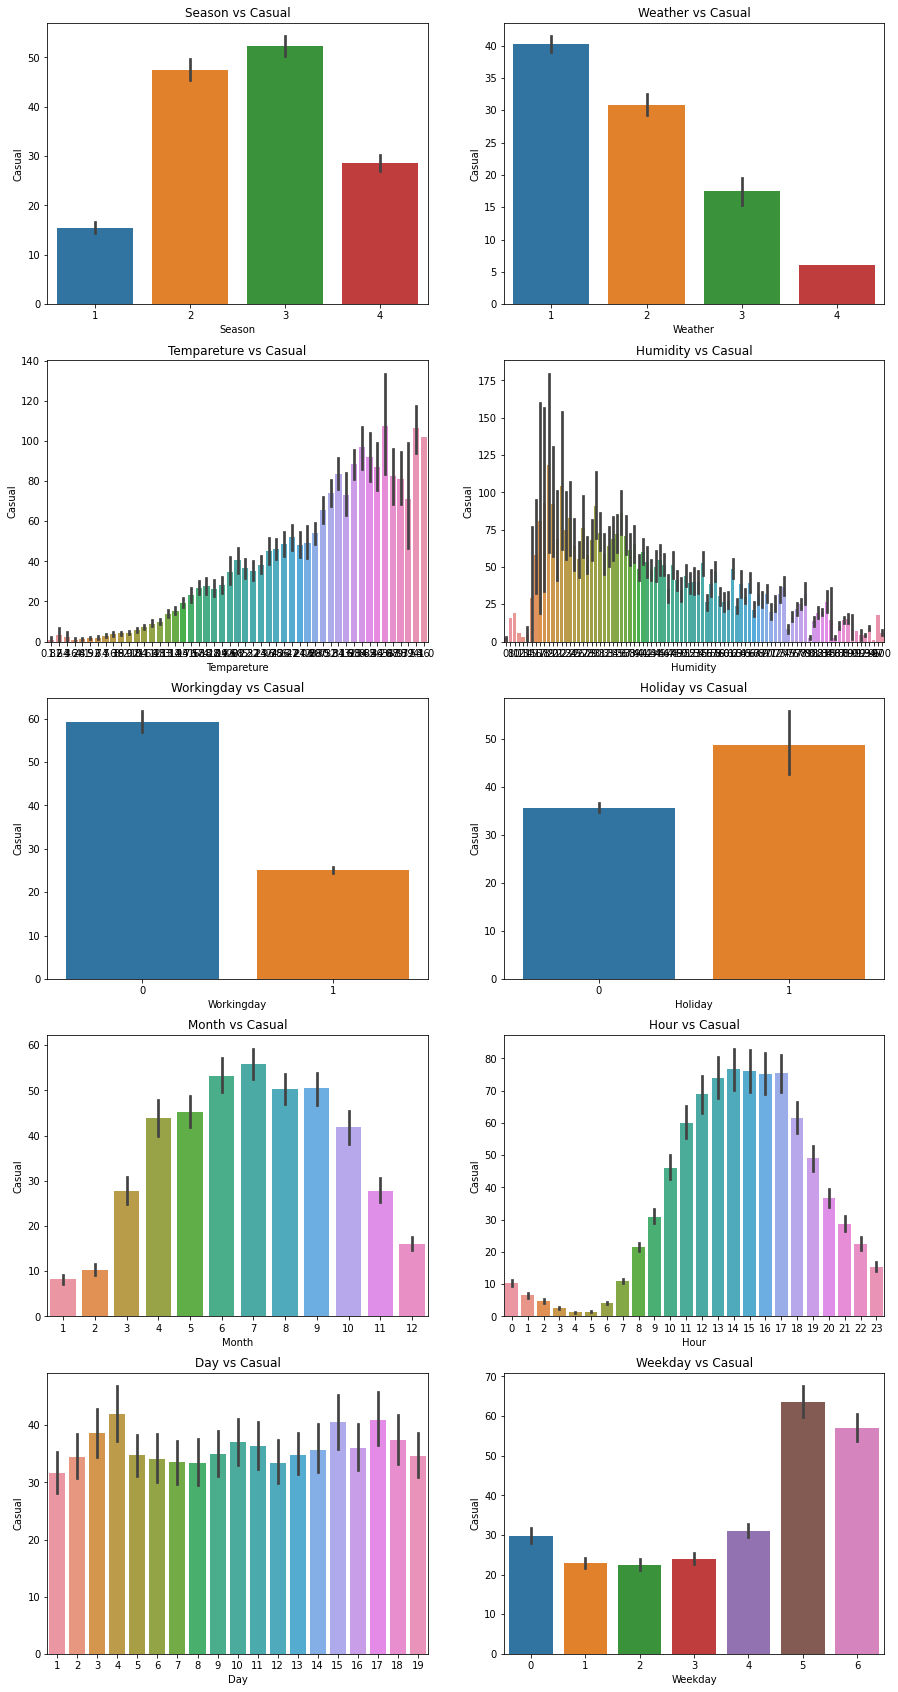

In [12]:
fig, axes = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(15, 30)
sns.barplot(data=train,y="casual",x="season",orient="v",ax=axes[0][0])
sns.barplot(data=train,y="casual",x="weather",orient="v",ax=axes[0][1])
sns.barplot(data=train,y="casual",x="temp",orient="v",ax=axes[1][0])
sns.barplot(data=train,y="casual",x="humidity",orient="v",ax=axes[1][1])
sns.barplot(data=train,y="casual",x="workingday",orient="v",ax=axes[2][0])
sns.barplot(data=train,y="casual",x="holiday",orient="v",ax=axes[2][1])
sns.barplot(data=train,y="casual",x="month",orient="v",ax=axes[3][0])
sns.barplot(data=train,y="casual",x="hour",orient="v",ax=axes[3][1])
sns.barplot(data=train,y="casual",x="day",orient="v",ax=axes[4][0])
sns.barplot(data=train,y="casual",x="weekday",orient="v",ax=axes[4][1])

axes[0][0].set(xlabel='Season', ylabel='Casual',title="Season vs Casual")
axes[0][1].set(xlabel='Weather', ylabel='Casual',title="Weather vs Casual")
axes[1][0].set(xlabel='Tempareture', ylabel='Casual',title="Tempareture vs Casual")
axes[1][1].set(xlabel='Humidity', ylabel='Casual',title="Humidity vs Casual")
axes[2][0].set(xlabel='Workingday', ylabel='Casual',title="Workingday vs Casual")
axes[2][1].set(xlabel='Holiday', ylabel='Casual',title="Holiday vs Casual")
axes[3][0].set(xlabel='Month', ylabel='Casual',title="Month vs Casual")
axes[3][1].set(xlabel='Hour', ylabel='Casual',title="Hour vs Casual")
axes[4][0].set(xlabel='Day', ylabel='Casual',title="Day vs Casual")
axes[4][1].set(xlabel='Weekday', ylabel='Casual',title="Weekday vs Casual")

## registered と説明変数の関係

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Registered'),
 Text(0.5, 1.0, 'Weekday vs Registered')]

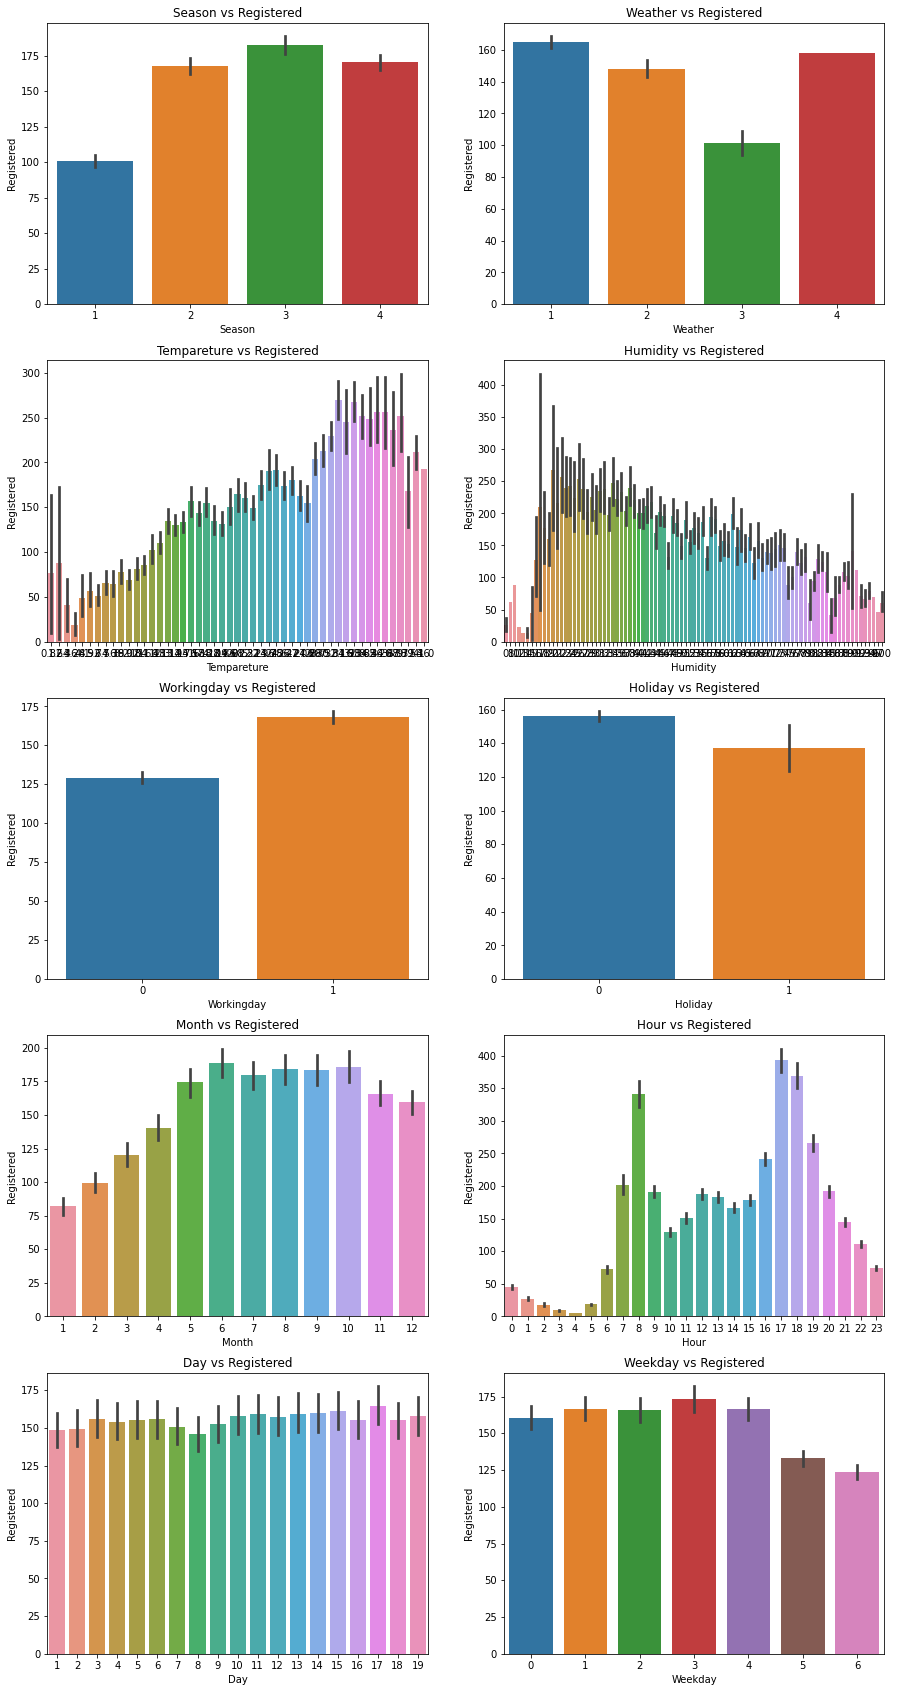

In [13]:
fig, axes = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(15, 30)
sns.barplot(data=train,y="registered",x="season",orient="v",ax=axes[0][0])
sns.barplot(data=train,y="registered",x="weather",orient="v",ax=axes[0][1])
sns.barplot(data=train,y="registered",x="temp",orient="v",ax=axes[1][0])
sns.barplot(data=train,y="registered",x="humidity",orient="v",ax=axes[1][1])
sns.barplot(data=train,y="registered",x="workingday",orient="v",ax=axes[2][0])
sns.barplot(data=train,y="registered",x="holiday",orient="v",ax=axes[2][1])
sns.barplot(data=train,y="registered",x="month",orient="v",ax=axes[3][0])
sns.barplot(data=train,y="registered",x="hour",orient="v",ax=axes[3][1])
sns.barplot(data=train,y="registered",x="day",orient="v",ax=axes[4][0])
sns.barplot(data=train,y="registered",x="weekday",orient="v",ax=axes[4][1])

axes[0][0].set(xlabel='Season', ylabel='Registered',title="Season vs Registered")
axes[0][1].set(xlabel='Weather', ylabel='Registered',title="Weather vs Registered")
axes[1][0].set(xlabel='Tempareture', ylabel='Registered',title="Tempareture vs Registered")
axes[1][1].set(xlabel='Humidity', ylabel='Registered',title="Humidity vs Registered")
axes[2][0].set(xlabel='Workingday', ylabel='Registered',title="Workingday vs Registered")
axes[2][1].set(xlabel='Holiday', ylabel='Registered',title="Holiday vs Registered")
axes[3][0].set(xlabel='Month', ylabel='Registered',title="Month vs Registered")
axes[3][1].set(xlabel='Hour', ylabel='Registered',title="Hour vs Registered")
axes[4][0].set(xlabel='Day', ylabel='Registered',title="Day vs Registered")
axes[4][1].set(xlabel='Weekday', ylabel='Registered',title="Weekday vs Registered")

# モデル構築

## ラッソ回帰

In [16]:
from sklearn.linear_model import Lasso,LassoCV

alphas = 10**np.linspace(-5, 10, 500)

Lasso_cv = LassoCV(alphas=alphas, cv=10)
Lasso_cv.fit(train_0, train_y)
print(f"best_alpha:{Lasso_cv.alpha_}")

Lasso = Lasso(alpha=Lasso_cv.alpha_)
Lasso.fit(train_0, train_y)
print(f"fit_score:{Lasso.score(train_0, train_y)}")
Lasso_train_y_pred = Lasso.predict(test_0)
Lasso_train_y_pred

best_alpha:1.122277356208507
fit_score:0.38886268716041006


array([-27.40177543, -23.3264008 , -15.60507749, ..., 288.04393302,
       306.50281408, 295.33217926])

In [17]:
# マイナスの処理
sub0 = pd.concat([test_datetime, pd.Series(Lasso_train_y_pred)], axis=1)
sub0.columns = ['datetime','count']
sub0['count'][sub0['count'] < 0] = 0
sub0

,datetime,count
0,2011-01-20 00:00:00,0.000000
1,2011-01-20 01:00:00,0.000000
2,2011-01-20 02:00:00,0.000000
3,2011-01-20 03:00:00,0.000000
4,2011-01-20 04:00:00,2.308528
...,...,...
6488,2012-12-31 19:00:00,271.315302
6489,2012-12-31 20:00:00,279.036625
6490,2012-12-31 21:00:00,288.043933
6491,2012-12-31 22:00:00,306.502814


In [ ]:
sub0.to_csv('bike_lasso.csv', index = False)

## リッジ回帰(ラッソより時間かかる)

In [19]:
from sklearn.linear_model import Ridge,RidgeCV

alphas = 10**np.linspace(-5, 10, 500)

Ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring='r2')
Ridge_cv.fit(train_0, train_y)
print(f"best_alpha:{Ridge_cv.alpha_}")

Ridge = Ridge(alpha=Ridge_cv.alpha_)
Ridge.fit(train_0, train_y)
print(f"fit_score:{Ridge.score(train_0, train_y)}")
Ridge_train_y_pred = Ridge.predict(test_0)
Ridge_train_y_pred

best_alpha:265.98043955937584
fit_score:0.38891947791192416


array([-25.18745994, -22.05239614, -14.2979977 , ..., 303.97544815,
       322.33278845, 311.55807284])

In [20]:
sub0 = pd.concat([test_datetime, pd.Series(Ridge_train_y_pred)], axis=1)
sub0.columns = ['datetime','count']
sub0['count'][sub0['count'] < 0] = 0
sub0

,datetime,count
0,2011-01-20 00:00:00,0.000000
1,2011-01-20 01:00:00,0.000000
2,2011-01-20 02:00:00,0.000000
3,2011-01-20 03:00:00,0.000000
4,2011-01-20 04:00:00,4.129574
...,...,...
6488,2012-12-31 19:00:00,284.143017
6489,2012-12-31 20:00:00,291.897415
6490,2012-12-31 21:00:00,303.975448
6491,2012-12-31 22:00:00,322.332788


In [ ]:
sub0.to_csv('bike_ridge.csv', index = False)

## ElasticNet

In [21]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

alphas = 10**np.linspace(-5, 10, 500)

Elastic_cv = ElasticNetCV(alphas=alphas, cv=10)
Elastic_cv.fit(train_0, train_y)
print(f"best_alpha:{Elastic_cv.alpha_}")

Elastic = ElasticNet(alpha=Elastic_cv.alpha_)
Elastic.fit(train_0, train_y)
print(f"fit_score:{Elastic.score(train_0, train_y)}")
Elastic_train_y_pred = Elastic.predict(test_0)
Elastic_train_y_pred

best_alpha:0.028636097185081158
fit_score:0.38918798408172584


array([-26.65876207, -23.73012422, -15.96629524, ..., 307.82617463,
       326.14420308, 315.46336333])

In [23]:
sub0 = pd.concat([test_datetime, pd.Series(Elastic_train_y_pred)], axis=1)
sub0.columns = ['datetime','count']
sub0['count'][sub0['count'] < 0] = 0
sub0

,datetime,count
0,2011-01-20 00:00:00,0.000000
1,2011-01-20 01:00:00,0.000000
2,2011-01-20 02:00:00,0.000000
3,2011-01-20 03:00:00,0.000000
4,2011-01-20 04:00:00,2.573382
...,...,...
6488,2012-12-31 19:00:00,287.810988
6489,2012-12-31 20:00:00,295.574817
6490,2012-12-31 21:00:00,307.826175
6491,2012-12-31 22:00:00,326.144203


In [ ]:
sub0.to_csv('bike_elastic.csv', index = False)

## ElasticNet (count log)

In [ ]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

alphas = 10**np.linspace(-5, 10, 500)

Elastic_cv = ElasticNetCV(alphas=alphas, cv=10)
Elastic_cv.fit(train_0, train_y_log)
print(f"best_alpha:{Elastic_cv.alpha_}")

Elastic = ElasticNet(alpha=Elastic_cv.alpha_)
Elastic.fit(train_0, train_y_log)
print(f"fit_score:{Elastic.score(train_0, train_y_log)}")
Elastic_train_y_pred_log = Elastic.predict(test_0)
Elastic_train_y_pred = np.exp(Elastic_train_y_pred_log)-1
print(Elastic_train_y_pred)

In [ ]:
print(pd.Series(Elastic_train_y_pred).min())
sub0 = pd.concat([test_datetime, pd.Series(Elastic_train_y_pred)], axis=1)
sub0.columns = ['datetime','count']
sub0

In [ ]:
sub0.to_csv('bikelogerastic.csv', index = False)
# 1.04088